# Super resolution on medical images:

Idea of this project is to create a model that is able to output a high resolution image from a low resolution one, based on the assumption that it can be trained on both high and low resolution inputs. See [github](https://github.com/marvande/image_super_resolution) for report and more information. 

[Link to doc Fastai](https://github.com/hiromis/notes/blob/master/Lesson7.md)

## Set-up:
Start with importing the right functions and modules. 

### Global imports:

Change simulation number :) this number will be used to save your data so change it when you run with new parameters

In [195]:
sim = 9

In [2]:
import pandas as pd
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import tensorflow as tf
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from skimage import measure
from numpy import linalg as LA
import shutil

# Additional personal functions necessary to run the notebook. 
from  add_functions.model_create_data_functions import *
from  add_functions.plot_fx_model import *
from  add_functions.evaluation_metrics import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Set CUDA if available. 

In [4]:
torch.cuda.set_device(3)

### Paths to data: 

Input images:
- HR images: **(3, 502, 672)** original (3, 1004, 1344) cut in 4 pieces

MR and LR will be created below. 
- LR images: **(3, 125, 167)** original (3, 500, 669) cut in 4 pieces, downsampled by 2. 
- MR images: **(3, 250, 334)** original (3, 500, 669) cut in 4 pieces

Paths to data:


In [5]:
path = Path('../../../../../SCRATCH2/marvande/data/train/HR/')

# path to HR data:
path_hr = path / 'HR_patches_train/tiff_files'

# path to save LR and MR images:
path_lr = path / 'small-125/train'
path_mr = path / 'small-250/train'

# path to test images:
path_test = path/'HR_patches_test/cut_images/tiff_files/'

# path to save LR and MR test images:
path_lr_test = path / 'small-125/test'
path_mr_test = path / 'small-250/test'

assert path.exists(), f"need dataset @ {path}"
assert path_hr.exists()

Run cell below if you want to resize the data each time you run the notebook. Otherwise comment. 

In [6]:
! rm -r ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train
! rm -r ../../../../../SCRATCH2/marvande/data/train/HR/small-125/test
! rm -r ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train
! rm -r ../../../../../SCRATCH2/marvande/data/train/HR/small-250/test

## Create LR and MR data:

From this HR data, we create LR versions in `path_lr` and `path_mr` for training and testing. LR images will be of size `(3, 125, 167)` while MR images of size `(3, 250, 334)`. Both will be saved as lower quality than HR. 

#### Resizing training HR to MR, LR:

In [7]:
# create smaller image sets of lower quality the first time this nb is run:
new_size_lr = (167, 125)
sets = [(path_lr, new_size_lr), (path_mr, (334, 250))]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p} from {path_hr}")
        parallel(partial(resize_one, path=p, size=size, rel_to_path=path_hr),
                 ImageList.from_folder(path_hr).items)

resizing to (167, 125) into ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/tiff_files


resizing to (334, 250) into ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/tiff_files


Resize test HR to MR, LR:

In [8]:
# create smaller tests sets the first time this nb is run:
new_size_lr = (167, 125)
sets = [(path_lr_test, new_size_lr), (path_mr_test, (334, 250))]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p} from {path_test}")
        parallel(partial(resize_one, path=p, size=size, rel_to_path=path_test),
                 ImageList.from_folder(path_test).items)

resizing to (167, 125) into ../../../../../SCRATCH2/marvande/data/train/HR/small-125/test from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_test/cut_images/tiff_files


resizing to (334, 250) into ../../../../../SCRATCH2/marvande/data/train/HR/small-250/test from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_test/cut_images/tiff_files


#### Evaluate resizing in a test image: 
To have an idea about what exactly happens to the pixels and images during resizing, we test it out on one image. 

In [9]:
path_t = '../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/tiff_files/'
file_p = path_t + '0013_[39667,16250]_part_1_1_.tif' 
file_name = 'HR_test.tif'
file = PIL.Image.open(file_p)
file.save('test/HR/'+file_name)

p_hr = Path('test/HR/')
p_lr = Path('test/LR')
p_mr = Path('test/MR')

size_lr_test = (167, 125)

# create smaller image sets of lower quality the first time this nb is run:
sets = [(Path('test/LR/'), size_lr_test), (Path('test/MR/'), (334, 250))]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p} from {p_hr}")
        parallel(partial(resize_one, path=p, size=size, rel_to_path = p_hr),
                 ImageList.from_folder('test/HR/').items)

MR VS HR: Frobenius diff: 9.8090 frob, Nuclear diff: 165.2214
MR VS HR: MSE: 19.6178, NMSE: 0.0193, PSNR: 35.2043, SSIM: 0.9872

LR VS HR: Frobenius diff: 21.7091 frob, Nuclear diff: 310.5509
LR VS HR: MSE: 92.4003, NMSE: 0.0419, PSNR: 28.4741, SSIM: 0.9428



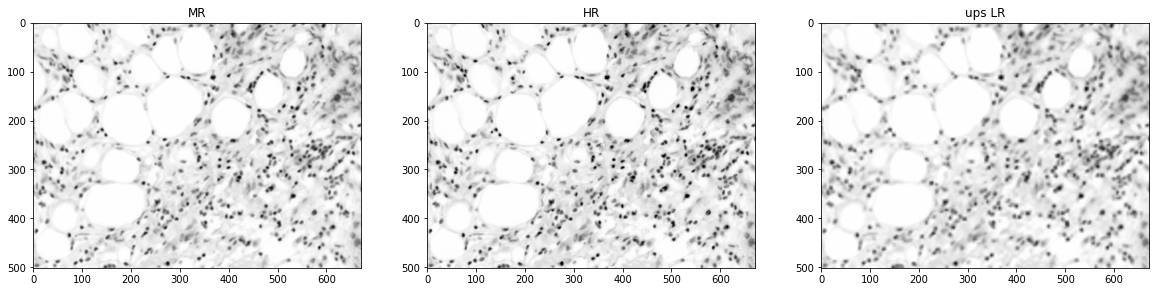

In [10]:
# Compare images after resizing:
HR_tens = scaler(open_image(p_hr/file_name).data)

img_mr = PIL.Image.open(p_mr/file_name)
img_mr = img_mr.resize((672, 502), resample=PIL.Image.BICUBIC).convert('RGB')
MR_tens = scaler(trans1(img_mr))

#evaluate norm between MR, HR:
evaluate_metrics(HR_tens.numpy(), MR_tens.numpy(), 'MR VS HR')
print('')

img_lr = PIL.Image.open(p_lr/file_name)
img_lr = img_lr.resize((672, 502), resample=PIL.Image.BICUBIC).convert('RGB')
LR_tens = scaler(trans1(img_lr))

#evaluate norm between MR, HR:
evaluate_metrics(HR_tens.numpy(), LR_tens.numpy(), 'LR VS HR')
print('')

plot_triple(MR_tens.numpy()[0,:,:], HR_tens.numpy()[0,:,:], LR_tens.numpy()[0,:,:], 'MR','HR', 'ups LR')

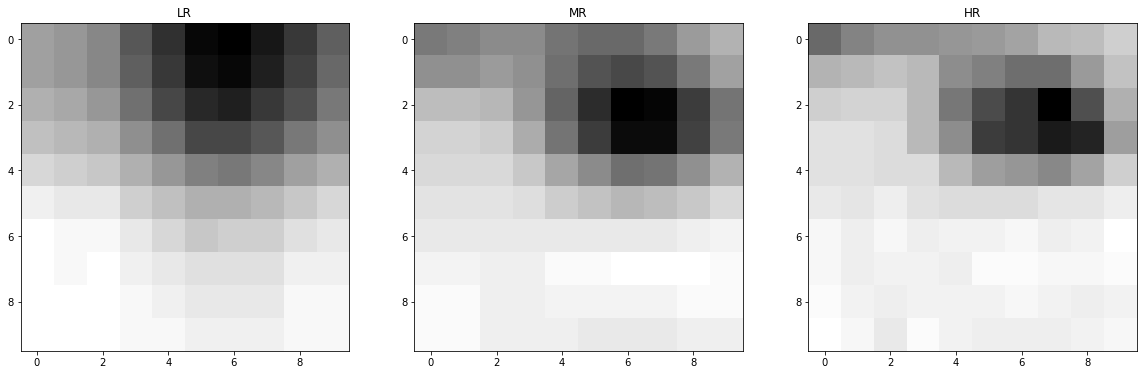

In [11]:
plot_triple(LR_tens.numpy()[0,0:10,0:10], MR_tens.numpy()[0,0:10,0:10],
            HR_tens.numpy()[0,0:10,0:10], 'LR', 'MR', 'HR')

### Training, validation and test data:

#### Data phase 1:
During phase 1, the model is trained on images of size `(3, 250, 334)`. Therefore HR images (originally of size  `(3, 502, 672)`) are down-sampled by approximately a factor 2 and LR images (originally of size  `(3, 125, 334)`) up-sampled by 2. 

In [12]:
# first phase data is LR data upsampled by factor 2:
bs, size = 15, (250, 334)
data_phase1 = get_data(bs, size, path_lr_test, path_lr, path_hr)
print(f'Test origin {path_lr_test}')
data_phase1

Test origin ../../../../../SCRATCH2/marvande/data/train/HR/small-125/test


ImageDataBunch;

Train: LabelList (1851 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train;

Valid: LabelList (205 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train;

Test: LabelList (336 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: EmptyLabelList
,,,,
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train

Have a look at a few data from the validation data. Left are the LR while right the corresponding Hr images. Furthermore, we evaluate some metrics to look at their similarity. 

LR data shape [3, 250, 334] and HR shape [3, 250, 334]
LR vs HR phase 1: Frobenius diff: 5.7585 frob, Nuclear diff: 71.1713
LR vs HR phase 1: MSE: 26.1032, NMSE: 0.0229, PSNR: 33.9639, SSIM: 0.9651


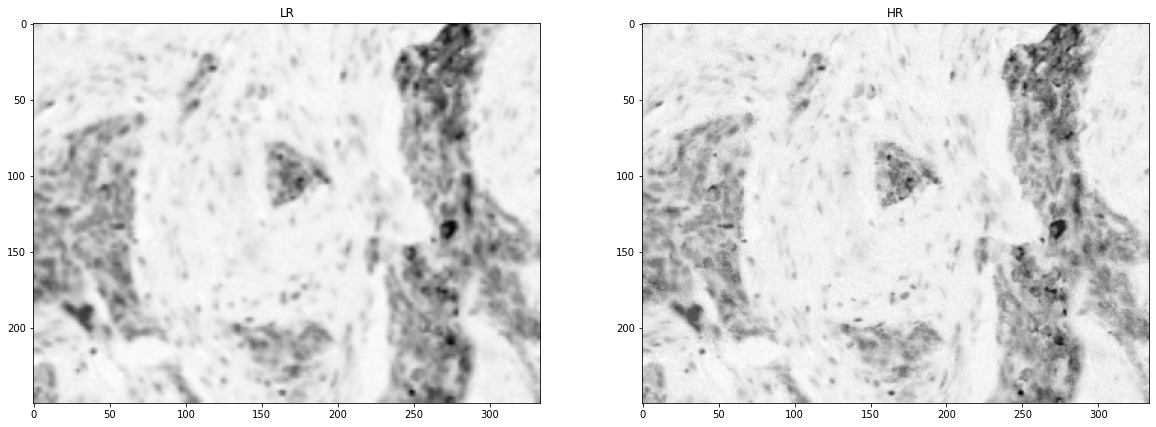

In [13]:
LR_tens = data_phase1.one_batch(ds_type=DatasetType.Valid)[0][1]
HR_tens = data_phase1.one_batch(ds_type=DatasetType.Valid)[1][1]
print('LR data shape {} and HR shape {}'.format(list(LR_tens.numpy().shape),
                                                list(HR_tens.numpy().shape)))
evaluate_metrics(LR_tens.numpy(), HR_tens.numpy(), 'LR vs HR phase 1')
plot_double(scaler(LR_tens).numpy()[0, :, :], scaler(HR_tens).numpy()[0, :, :], 'LR', 'HR')

#### Data phase 2:
During phase 2, the model is trained on images of size `(3, 502, 672)`. Therefore LR images (originally of size  `(3, 125, 334)`) up-sampled by approximately 4. 

In [14]:
bs, new_size = 4, (502, 672)
data_phase2 = get_data(bs, new_size, path_lr_test, path_lr, path_hr)
data_phase2

ImageDataBunch;

Train: LabelList (1851 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train;

Valid: LabelList (205 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train;

Test: LabelList (336 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: EmptyLabelList
,,,,
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train

Have a look at a few data from the validation data. Left are the LR while right the corresponding Hr images. Furthermore, we evaluate some metrics to look at their similarity. 

LR data shape [3, 502, 672] and HR shape [3, 502, 672]
LR vs HR phase 1: Frobenius diff: 17.4040 frob, Nuclear diff: 301.2155
LR vs HR phase 1: MSE: 62.9437, NMSE: 0.0355, PSNR: 30.1413, SSIM: 0.8970


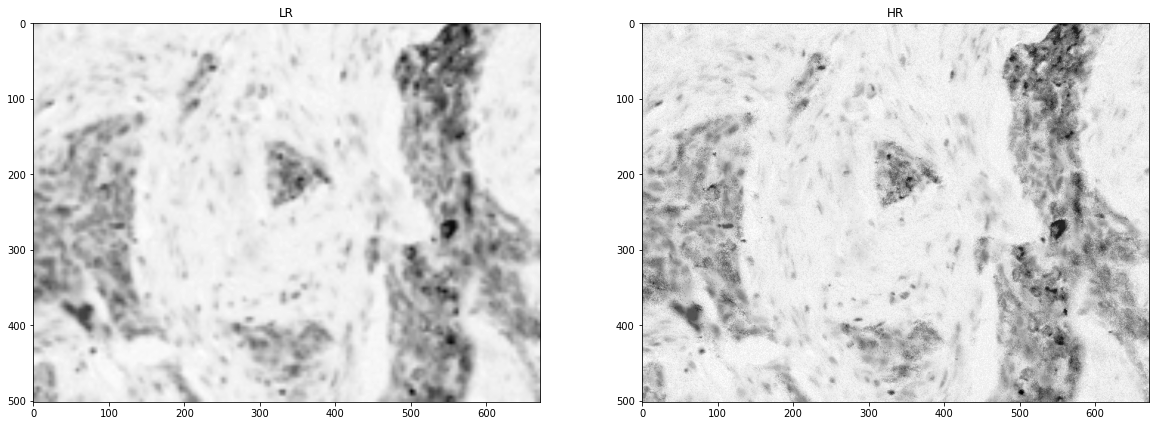

In [15]:
LR_tens = data_phase2.one_batch(ds_type=DatasetType.Valid)[0][1]
HR_tens = data_phase2.one_batch(ds_type=DatasetType.Valid)[1][1]
print('LR data shape {} and HR shape {}'.format(list(LR_tens.numpy().shape),
                                                list(HR_tens.numpy().shape)))
evaluate_metrics(LR_tens.numpy(), HR_tens.numpy(), 'LR vs HR phase 1')
plot_double(
    scaler(LR_tens).numpy()[0, :, :],
    scaler(HR_tens).numpy()[0, :, :], 'LR', 'HR')

## Feature loss: 
Create loss metrics used in the model. 

In [142]:
def gram_matrix(x):
    """
    Gram matrix of a set of vectors in an inner 
    product space is the Hermitian matrix of inner products
    """
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

Select the data of an image and use it to compute its Gram matrix. 

In [143]:
im = data_phase1.valid_ds[0][1]
t = im.data
t = torch.stack([t,t])

In [144]:
gram_matrix(t)

tensor([[[0.2957, 0.3039, 0.2875],
         [0.3039, 0.3125, 0.2959],
         [0.2875, 0.2959, 0.2840]],

        [[0.2957, 0.3039, 0.2875],
         [0.3039, 0.3125, 0.2959],
         [0.2875, 0.2959, 0.2840]]])

We define a base loss as the L1 loss (`F.l1_loss`). 

In [145]:
base_loss = F.l1_loss

Construct a pre-trained `vgg16` model ([Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)). VGG is another Convolutional Neural Network (CNN) architecture devised in 2014, the 16 layer version is utilised in the loss function for training this model. VGG model. a network pretrained on ImageNet, is used to evaluate the generator model’s loss.


Further, we set `requires_grad` to `False` as this is useful when you want to freeze part of your model, or you know in advance that you are not going to use gradients w.r.t. some parameters. 

<img src = 'images/vgg16-1-e1542731207177.png'>


The head of the VGG model is the final layers shown as fully connected and softmax in the above diagram. This head is ignored and the loss function uses the intermediate activations in the backbone of the network, which represent the feature detections.

<img src = 'images/0_3oRr_BjTm49I8qge.png'>

Those activations can be found by looking through the VGG model to find all the max pooling layers. These are where the grid size changes and features are detected. So we need to select those layers.

Create a VGG model - just using the pre-trained model. In VGG, there's a attribute called `.features` which contains the convolutional part of the model. So vgg16_bn(True).features is the convolutional part of the VGG model. Because we don't need the head. We only want the intermediate activations. Then we'll check that on the GPU, we'll put it into eval mode because we're not training it. And we'll turn off `requires_grad` because we don't want to update the weights of this model. We're just using it for inference (i.e. for the loss).

In [146]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Select the layer IDs of `MaxPool2d` blocks. Enumerate through all the children of that model and find all of the max pooling layers, because in the VGG model that's where the grid size changes.

In [147]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

So we grab layer i-1. That's the layer before it changes. So there's our list of layer numbers just before the max pooling layers ([5, 12, 22, 32, 42]). All of those are ReLU's, not surprisingly. Those are where we want to grab some features from, and so we put that in blocks - it's just a list of ID's.

Create the feature loss from the model and layer ids selected above. 

Source: 
- [Article 1](https://towardsdatascience.com/loss-functions-based-on-feature-activation-and-style-loss-2f0b72fd32a9)
- [Article 2](https://towardsdatascience.com/deep-learning-based-super-resolution-without-using-a-gan-11c9bb5b6cd5)

Main points:
- Loss functions using these techniques can be used during the training of U-Net based model architectures
- Feature loss: loss function used is similar to the loss function in the the [paper](https://arxiv.org/abs/1603.08155), using VGG-16 but also combined with pixel mean squared error loss loss and gram matrix style loss
- The training of a model can use this loss function based on the VGG model’s activations. The loss function remains fixed throughout the training unlike the critic part of a GAN
- Feature loss:  Feature map has 256 channels by 28 by 28. The activations at the same layer for the (target) original image and the generated image are compared using mean squared error or the least absolute error (L1) error for the base loss. These are feature losses. This error function uses L1 error. This allows the loss function to know what features are in the target ground truth image and to evaluate how well the model’s prediction’s features match these rather than only comparing pixel difference. This allows the model being trained with this loss function to produce much finer detail in the generated/predicted features and output.
- Gram matrix style loss: A gram matrix defines a style with respect to specific content. By calculating the gram matrix for each feature activation in the target/ground truth image, it allows the style of that feature to be defined. If the same gram matrix is calculated from the activations of the predictions, the two can be compared to calculate how close the style of the feature prediction is to the target/ground truth image. A gram matrix is the matrix multiplication of the each of the activations and the activation matrix’s transpose. This enables the model to learn and generate predictions of images whose features look correct in their style and in context, with the end result looking more convincing and appear closer or the same as the target/ground truth.


**Predictions from models trained with this loss function:** The generated predictions from trained models using loss functions based on these techniques have both convincing fine detail and style. That style and fine detail may be different aspects of image quality be predicting fine pixel detail or the predicting correct colours.

In [148]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        #feat losses
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        #gram: 
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Training:

### Set up: 

In [196]:
# learning rate:
lr = 1e-3
#weight decay:
wd = 1e-3

def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    """
    do_fit: fits during 10 epochs with feature loss. 
    """
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name, return_path=True)
    learn.show_results(rows=1, imgsize=10)
    learn.recorder.plot_losses()
    learn.recorder.plot_metrics()

In case pytorch is using too much memory and need to reset:

In [197]:
# delete all tensors and free cache:
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  1663
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 10549


[GPUMemory(total=12212, free=11525, used=687),
 GPUMemory(total=12196, free=12185, used=10),
 GPUMemory(total=12196, free=12185, used=10),
 GPUMemory(total=12212, free=1663, used=10549)]

In [198]:
#resnet 34 given as an encoder in downsampling section of unet
arch = models.resnet34
learn = unet_learner(data_phase1,
                     arch,
                     wd=wd,
                     loss_func=feat_loss,
                     callback_fns=LossMetrics,
                     blur=True,
                     norm_type=NormType.Weight)
gc.collect();

Plots loss according to learning rate to pick the best learning rate. 

In [ ]:
learn.lr_find()
learn.recorder.plot()

From this plot a learning rate of 1e-3 is chosen as it's approximately the middle of the descending curve. 

In [ ]:
lr = 1e-3

### Phase 1: 
During phase 1, the model is trained on images of size `(3, 250, 334)`. Therefore HR images (originally of size  `(3, 502, 672)`) are down-sampled by approximately a factor 2 and LR images (originally of size  `(3, 125, 334)`) up-sampled by 2. 

#### Phase 1 a: 
As per usual, because we're using a pre-trained network in our U-Net, we start with frozen layers for the downsampling path, train for a while. As you can see, we get not only the loss, but also the pixel loss and the loss at each of our feature layers, and then also something we'll learn about in part 2 called Gram loss which I don't think anybody's used for super resolution before as far as I know. 

lr = 0.01

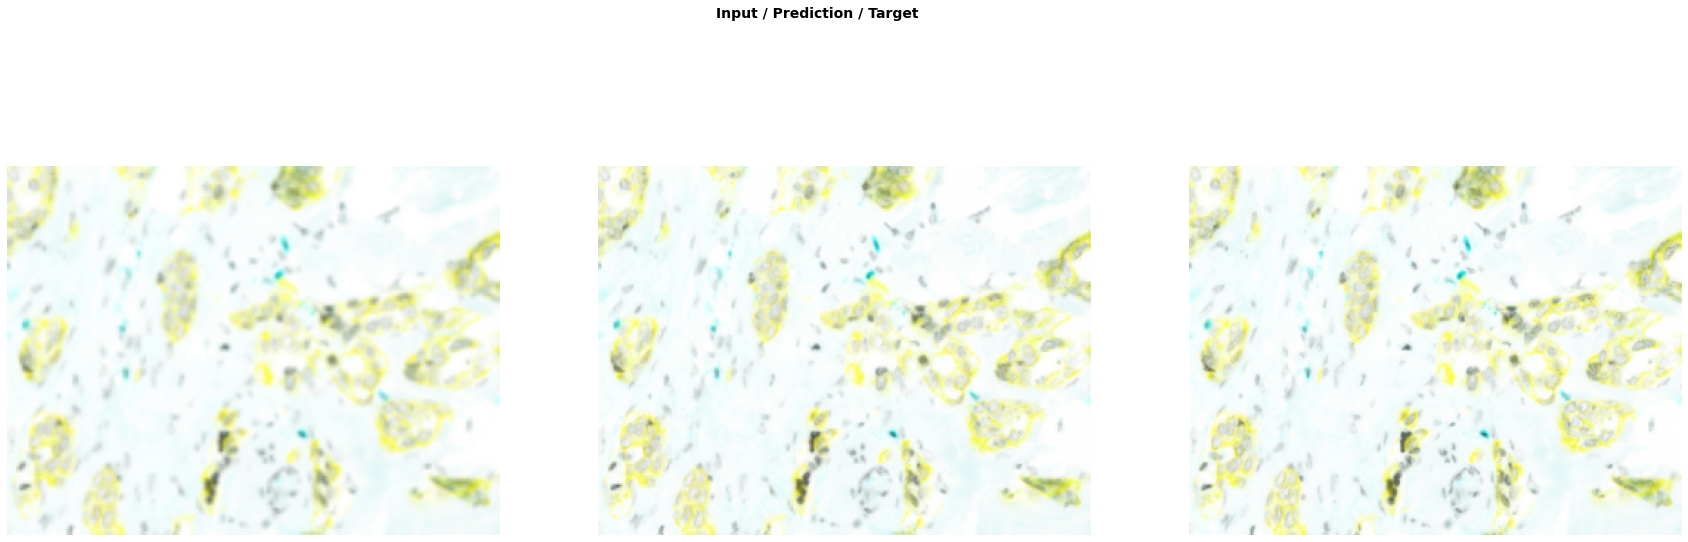

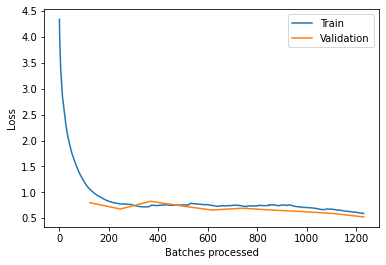

In [31]:
do_fit('sim{}_1a'.format(sim), slice(lr * 10))

Copy the learning object to another folder in order not to delete it when deleting paht_lr the data folder before resizing at the beginning of the notebook. 

In [32]:
shutil.copy(
    path_lr/'models/sim{}_1a.pth'.format(sim),
    '../../../../../SCRATCH2/marvande/data/train/HR/models/')

'../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_1a.pth'

#### Phase 1 b: 
We unfreeze and train some more. With smaller learning rates [1e-05 to 0.001]

In [33]:
learn.unfreeze()

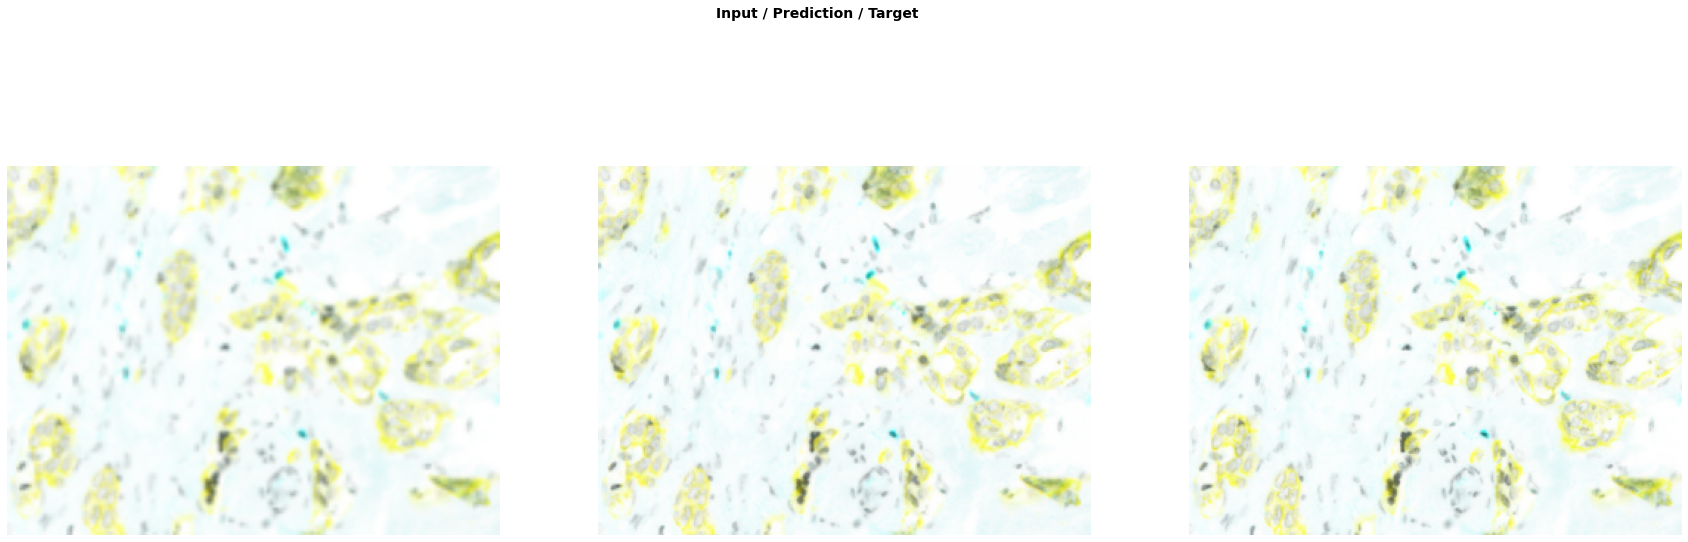

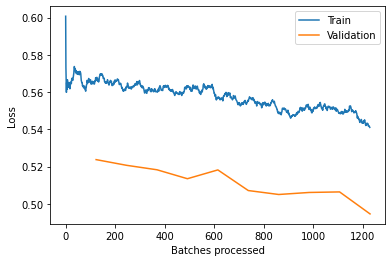

In [34]:
do_fit('sim{}_1b'.format(sim), slice(1e-5,lr))

In [35]:
shutil.copy(
    path_lr/'models/sim{}_1b.pth'.format(sim),
    '../../../../../SCRATCH2/marvande/data/train/HR/models/')

'../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_1b.pth'

### Phase 2: 
During phase 2, the model is trained on images of size `(3, 502, 672)`. Therefore LR images (originally of size  `(3, 125, 334)`) up-sampled by approximately 4. 

In [27]:
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  11629
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 583


[GPUMemory(total=12212, free=11525, used=687),
 GPUMemory(total=12196, free=12185, used=10),
 GPUMemory(total=12196, free=12185, used=10),
 GPUMemory(total=12212, free=11629, used=583)]

Then let's switch up to double the size. So we need to also halve the batch size to avoid running out of GPU memory, and freeze again, and train some more.

#### Phase 2 a: 
lr = 0.001

In [32]:
learn.data = data_phase2
learn.freeze()
gc.collect();

In [33]:
! mkdir ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/
! cp ../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_1b.pth ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/

mkdir: cannot create directory '../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/': File exists


In [34]:
learn.load('sim{}_1b'.format(sim));

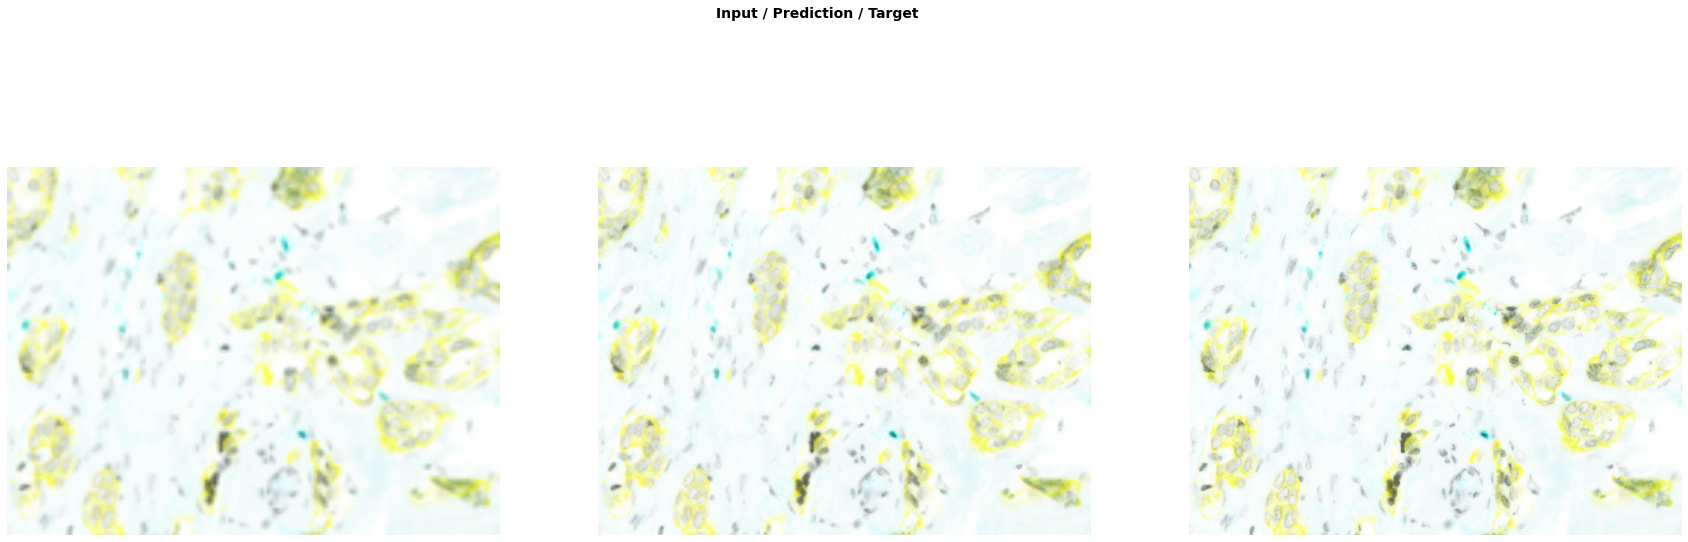

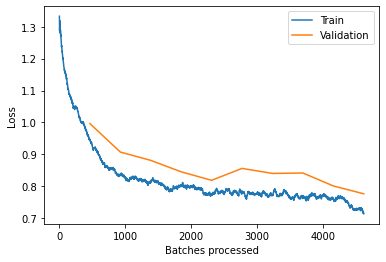

In [35]:
do_fit('sim{}_2a'.format(sim))

In [36]:
shutil.copy(
    path_lr/'models/sim{}_2a.pth'.format(sim),
    '../../../../../SCRATCH2/marvande/data/train/HR/models/')

'../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_2a.pth'

#### Phase 2 b:
smaller learning rates, lr = [1e-06 to 0.0001]

In [29]:
! mkdir ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/
! cp ../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_2a.pth ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/

mkdir: cannot create directory '../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/': File exists


In [30]:
learn.load('sim{}_2a'.format(sim));

In [31]:
learn.unfreeze()

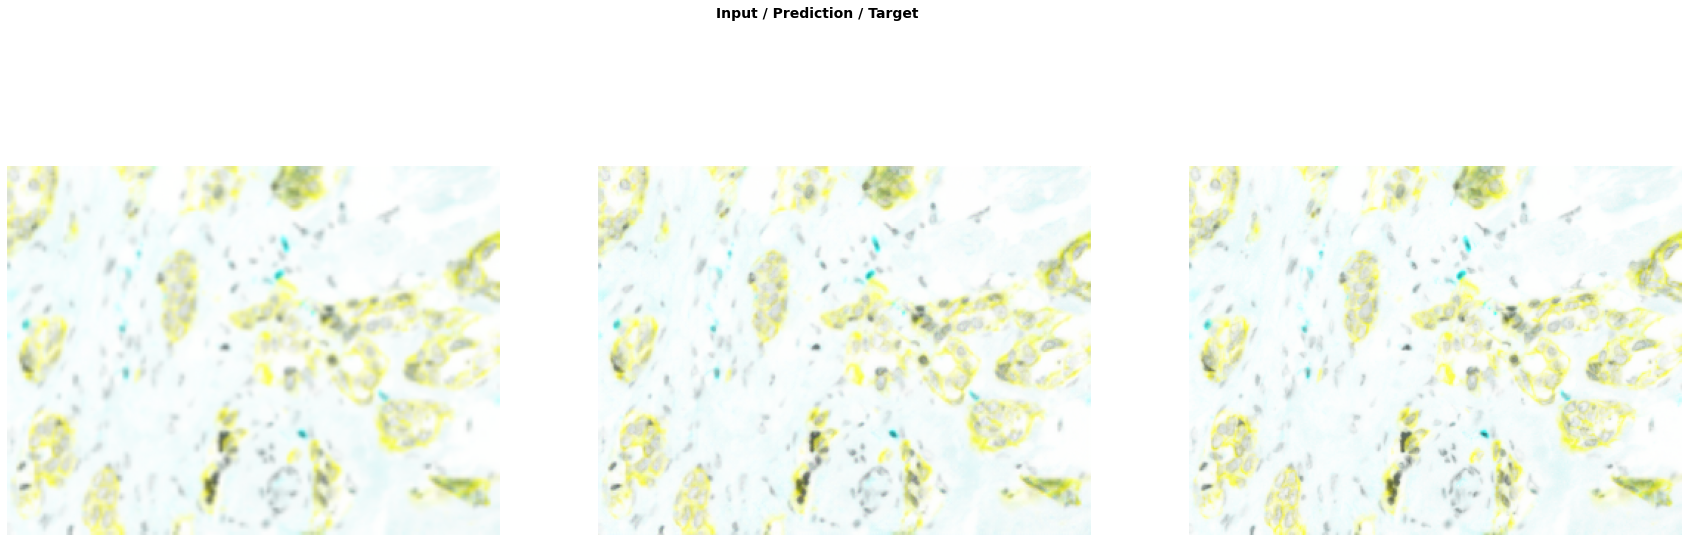

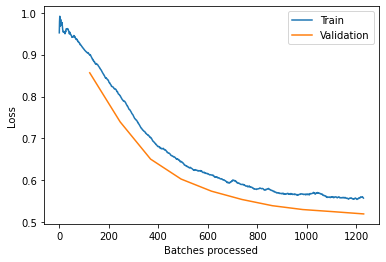

In [32]:
do_fit('sim{}_2b'.format(sim), slice(1e-6,1e-4))

In [33]:
shutil.copy(
    path_lr/'models/sim{}_2b.pth'.format(sim),
    '../../../../../SCRATCH2/marvande/data/train/HR/models/')

'../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_2b.pth'

## Testing : 

### Create test data:

Create testing data, `data_mr` and `data_lr` both upsampled to size `(3, 502, 672)`, except `data_mr` is upsampled from size `(3, 250, 334)` while `data_lr` is upsampled from size `(3, 125, 167)`. This way, we will test the model on both sets and see if one of them creates better HR images. 

In [199]:
size_hr = (3, 502, 672)
bs = 1

#upsampled by factor 4:
print('Upsample factor 4')
print(f'LR test from {path_lr_test}')
print(f'LR train from {path_lr}')
data_lr = get_data(bs, size_hr, path_lr_test, path_lr, path_hr)
print('')
print('Upsample factor 2')
#upsampled by factor 2: 
data_mr = get_data(bs, size_hr, path_mr_test, path_mr, path_hr)
print(f'LR test from {path_mr_test}')
print(f'LR train from {path_mr}')

Upsample factor 4
LR test from ../../../../../SCRATCH2/marvande/data/train/HR/small-125/test
LR train from ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train

Upsample factor 2
LR test from ../../../../../SCRATCH2/marvande/data/train/HR/small-250/test
LR train from ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train


In [200]:
# original HR test data:
data_hr = get_data(bs, size_hr, path_test, path_hr, path_hr)
print(f'LR test from {path_test}')
print(f'LR train from {path_hr}')

LR test from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_test/cut_images/tiff_files
LR train from ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/tiff_files


If model was somehow deleted from the `path_lr` folder in the process somewhere in the notebook, this will copy it from the folder where we saved it to earlier. 

In [207]:
! mkdir ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/
! cp ../../../../../SCRATCH2/marvande/data/train/HR/models/sim9_2b.pth ../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/

mkdir: cannot create directory '../../../../../SCRATCH2/marvande/data/train/HR/small-125/train/models/': File exists


Load the model from the last phase.

In [211]:
learn.load('sim{}_2b'.format(sim))
learn.data = data_mr

### Test on one image:

We first evaluate what the model predicts from one MR and LR image (the same obviously). 

In [212]:
num_im_test = 10
# Ground truth HR image:
mr = data_mr.test_ds.x.items[num_im_test]
im_mr = open_image(mr)

hr = data_hr.test_ds.x.items[num_im_test]
#transform to tensor:
HR_tens = open_image(hr).data

# LR version of the same image:
lr = data_lr.test_ds.x.items[num_im_test]
im_lr = open_image(lr)

# Check if it's the same image:
pattern_mr_lr = "test\/(.*?)\.tif"
pattern_hr = "tiff_files\/(.*?)\.tif"
assert (re.search(pattern_mr_lr,
                  str(mr)).group(1) == re.search(pattern_mr_lr,
                                                 str(lr)).group(1))
assert (re.search(pattern_hr,
                  str(hr)).group(1) == re.search(pattern_mr_lr,
                                                 str(lr)).group(1))

#### Upsample test image:
To be able to apply the model and predict the HR image from the LR, we need to resample the LR and MR image to be of the same size as the HR, as the model inputs and outputs images of the same size. 

HR and resized MR and LR shape [3, 502, 672], [3, 502, 672], [3, 502, 672]

ups LR VS HR: Frobenius diff: 32.5329 frob, Nuclear diff: 390.8117
ups LR VS HR: MSE: 204.3631, NMSE: 0.0597, PSNR: 25.0268, SSIM: 0.8685

ups MR VS HR: Frobenius diff: 23.4555 frob, Nuclear diff: 300.6457
ups MR VS HR: MSE: 107.7225, NMSE: 0.0433, PSNR: 27.8077, SSIM: 0.9204


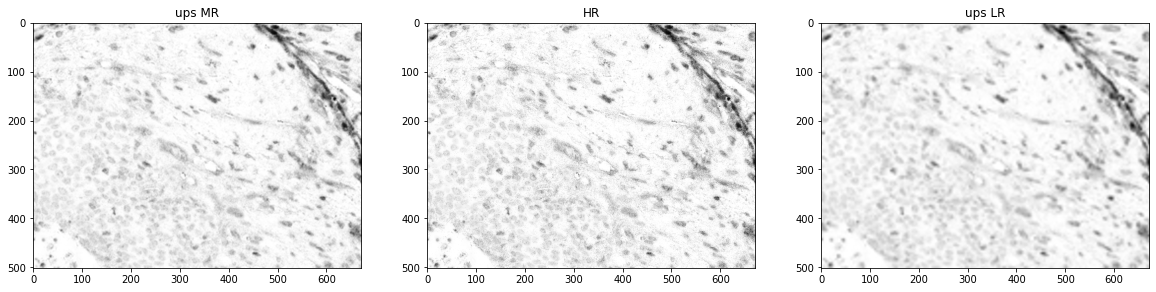

In [213]:
#resize LR to same size as HR:
img_lr = PIL.Image.open(lr).resize((672, 502),
                                   resample=PIL.Image.BICUBIC).convert('RGB')
LR_tens = scaler(trans1(img_lr))
assert (LR_tens.shape == HR_tens.shape)

#resize MR to same size as HR:
img_mr = PIL.Image.open(mr).resize((672, 502),
                                   resample=PIL.Image.BICUBIC).convert('RGB')
MR_tens = scaler(trans1(img_mr))
assert (MR_tens.shape == HR_tens.shape)

print('HR and resized MR and LR shape {}, {}, {}'.format(list(HR_tens.shape), list(MR_tens.shape),
                                              list(LR_tens.shape)))
print('')

#evaluate metrics between ups LR, HR:
evaluate_metrics(HR_tens.numpy(), LR_tens.numpy(), 'ups LR VS HR')
print('')
#evaluate metrics between ups MR, HR:
evaluate_metrics(HR_tens.numpy(), MR_tens.numpy(), 'ups MR VS HR')

plot_triple(MR_tens.numpy()[0, :, :],
            HR_tens.numpy()[0, :, :],
            LR_tens.numpy()[0, :, :], 'ups MR', 'HR', 'ups LR')

#### Prediction on test image:
Now that we have resized the LR and MR to the same size as the ground truth HR, we can feed it to the model and predict a new HR image.

In [214]:
# Prediction of model for ups LR:
p_lr, img_pred_lr, b_lr = learn.predict(Image(LR_tens))

# Prediction of model for ups MR:
p_mr, img_pred_mr, b_mr = learn.predict(Image(MR_tens))

# Assert reconstructed HR has same shape as ground truth HR:
assert (list(p_mr.shape) == list(HR_tens.shape))
assert (list(p_mr.shape) == list(HR_tens.shape))

Then we evaluate visually and mathematically how similar the predicted image is to the ground truth HR. We compare those metrics to the similarity metrics computed between the HR images created by simple bicubic interpolation from LR and MR and HR. Ideally, our model should do better than the interpolated images. 

ups LR VS HR: Frobenius diff: 32.5329 frob, Nuclear diff: 390.8117
ups LR VS HR: MAE: 9.860911, MSE: 204.3631, NMSE: 0.0597, PSNR: 25.0268, SSIM: 0.8685
pred HR from LR VS HR: Frobenius diff: 38.3930 frob, Nuclear diff: 393.1177
pred HR from LR VS HR: MAE: 15.314672, MSE: 286.8340, NMSE: 0.0707, PSNR: 23.5545, SSIM: 0.8706

ups MR VS HR: Frobenius diff: 23.4555 frob, Nuclear diff: 300.6457
ups MR VS HR: MAE: 8.156306, MSE: 107.7225, NMSE: 0.0433, PSNR: 27.8077, SSIM: 0.9204
pred HR from MR VS HR: Frobenius diff: 42.4859 frob, Nuclear diff: 336.1592
pred HR from MR VS HR: MAE: 17.531967, MSE: 348.6841, NMSE: 0.0780, PSNR: 22.7065, SSIM: 0.9139


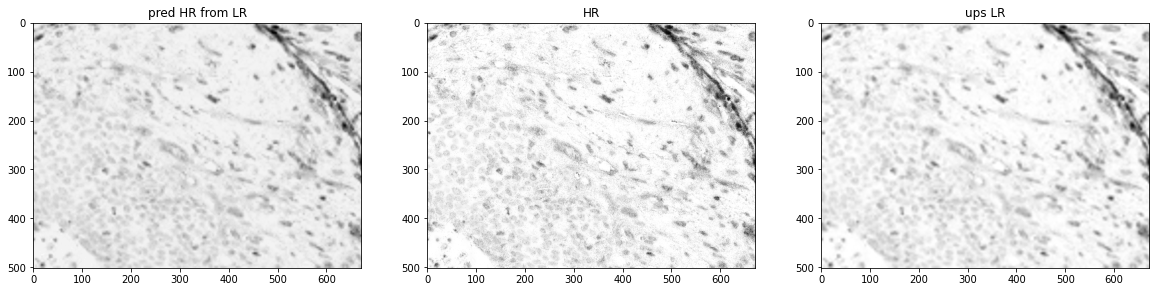

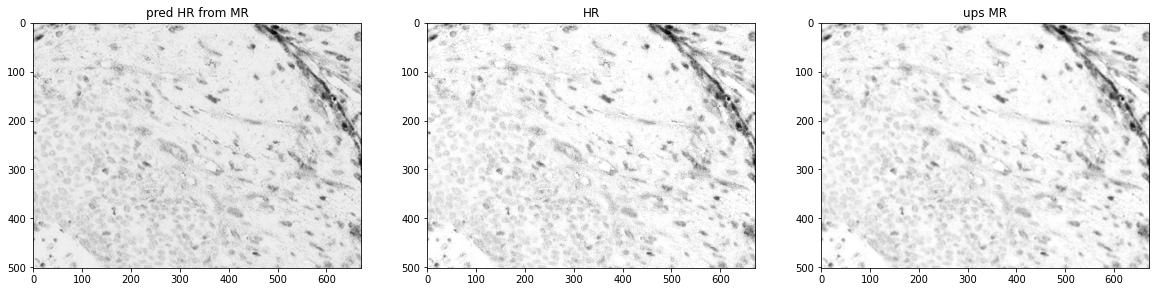

In [235]:
#evaluate metrics between pred HR HR from ups LR:
evaluate_metrics(HR_tens.numpy(), LR_tens.numpy(), 'ups LR VS HR')
evaluate_metrics(HR_tens.numpy(),
                 scaler(img_pred_lr).numpy(), 'pred HR from LR VS HR')

print('')
#evaluate metrics between pred HR HR from ups MR:
evaluate_metrics(HR_tens.numpy(), MR_tens.numpy(), 'ups MR VS HR')
evaluate_metrics(HR_tens.numpy(),
                 scaler(img_pred_mr).numpy(), 'pred HR from MR VS HR')

plot_triple(img_pred_lr.numpy()[0, :, :],
            HR_tens.numpy()[0, :, :],
            LR_tens.numpy()[0, :, :], 'pred HR from LR', 'HR', 'ups LR')

plot_triple(img_pred_mr.numpy()[0, :, :],
            HR_tens.numpy()[0, :, :],
            MR_tens.numpy()[0, :, :], 'pred HR from MR', 'HR', 'ups MR')

Visually our outputs look better though our metrics are worse though. This might be to their darker contrasts. 

### Evaluate on several images:

Now we evaluate the same thing as before but on a bunch of test images in order to get average prediction evaluations.

#### Plot different predictions:

Patient: 0131, Location: [46833,16191]
Patient: 0131, Location: [38831,10341]
Patient: 0131, Location: [50072,7868]
Patient: 0131, Location: [40734,12991]
Patient: 0131, Location: [38831,10341]
Patient: 0131, Location: [46800,15428]
Patient: 0131, Location: [42912,16664]
Patient: 0131, Location: [46589,13751]
Patient: 0131, Location: [40896,13825]
Patient: 0131, Location: [49577,17995]


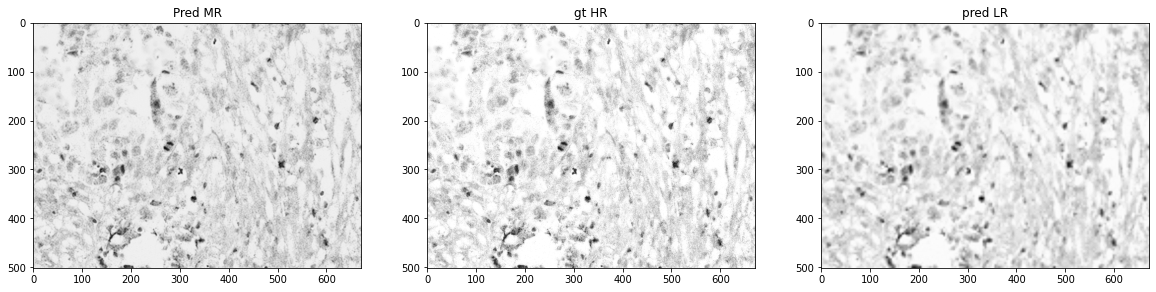

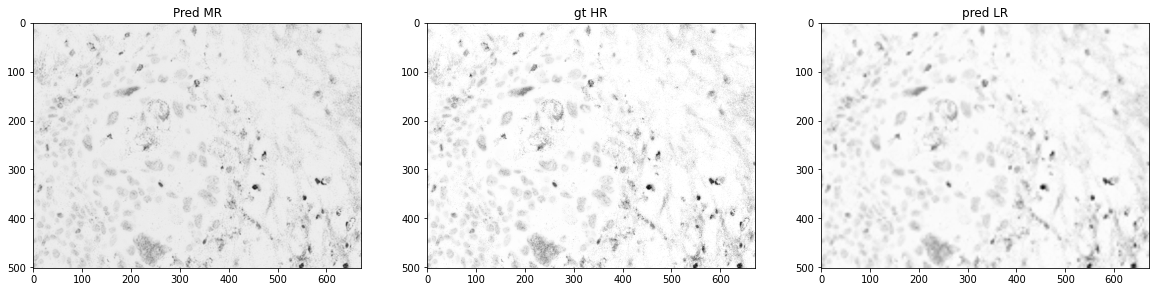

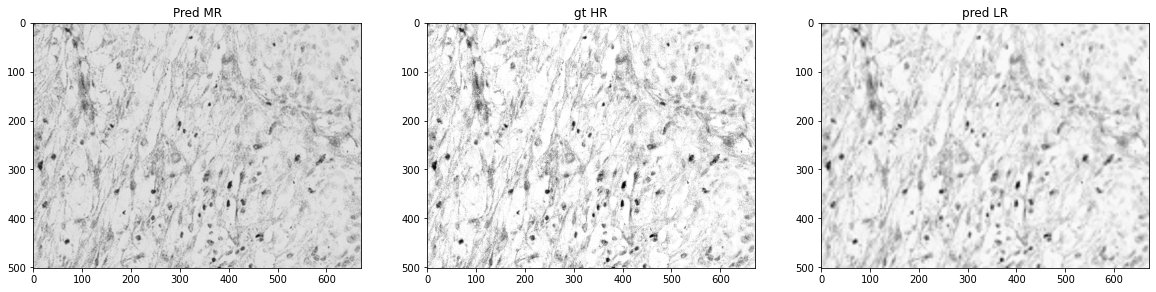

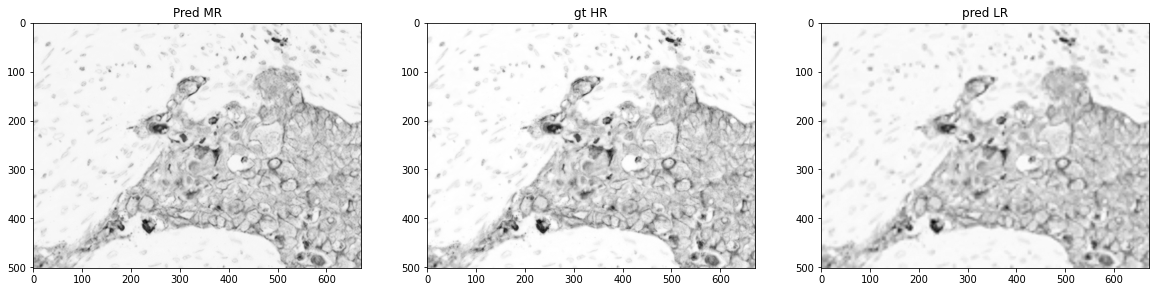

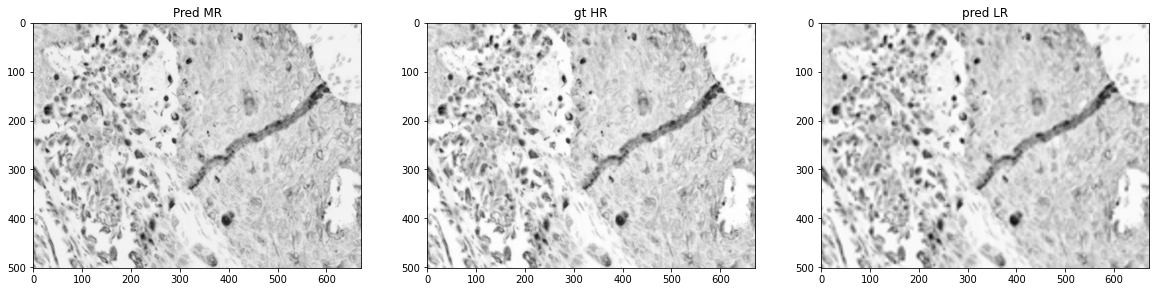

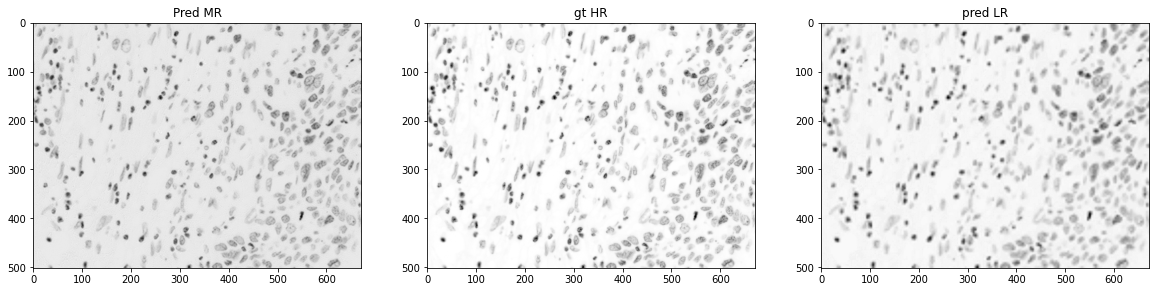

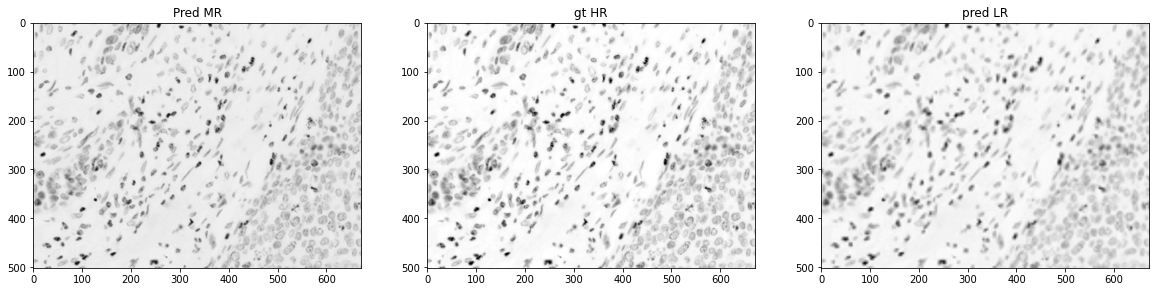

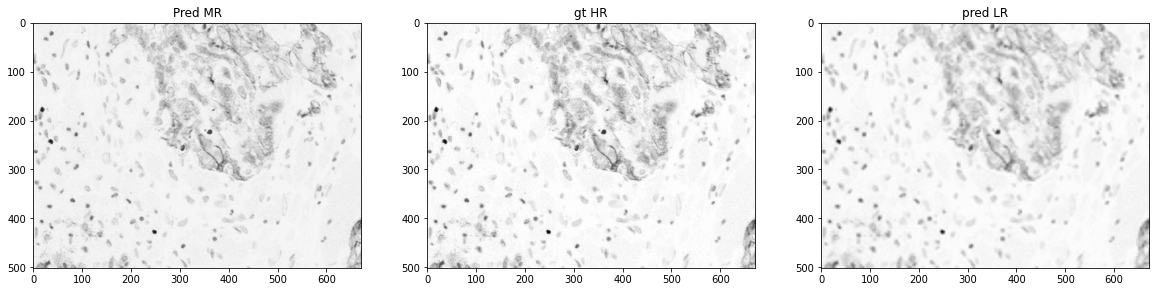

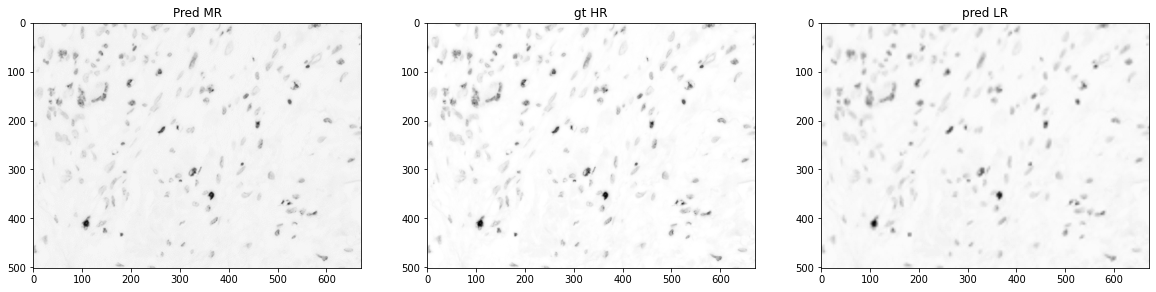

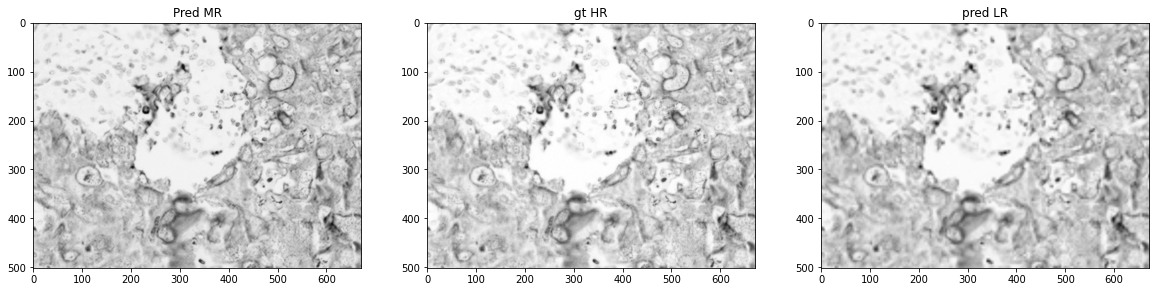

In [236]:
## Plot for several:
LR_list = ImageList.from_folder(path_lr_test).items
MR_list = ImageList.from_folder(path_mr_test).items
HR_list = ImageList.from_folder(path_test).items

plot_several_tests(learn, LR_list, MR_list, HR_list)

#### Loss and error metrics:

Evaluate measures on 20 test images. 

In [ ]:
# Create test table with results:
df_lr = eval_test_images_df(learn, path_lr_test, path_test, 'LR')
df_lr.to_csv('data/metrics/metrics_sim{}_lr.csv'.format(sim))
df_lr;

In [ ]:
df_mr = eval_test_images_df(learn, path_mr_test, path_test, 'MR')
df_mr.to_csv('data/metrics/metrics_sim{}_mr.csv'.format(sim))
df_mr;

In [265]:
av_metrics = median_avg_df(df_lr, 'LR').merge(median_avg_df(df_mr, 'MR'),
                                              on='metrics')
av_metrics_ups = median_avg_df(df_lr, 'LR',
                               ups=True).merge(median_avg_df(df_mr,
                                                             'MR',
                                                             ups=True),
                                               on='metrics')
av_metrics = av_metrics.merge(av_metrics_ups, on='metrics')
av_metrics.index = av_metrics['metrics']
av_metrics = av_metrics.drop('metrics', axis=1)
av_metrics.to_csv('data/metrics/av_metrics_sim{}.csv'.format(sim))
av_metrics

LR          MR     LR_ups      MR_ups
metrics                                                
avg_MAE   129.026062  220.914256  21.640876  125.846066
med_MAE   125.703681  281.379998  18.046586  114.851692
avg_MSE   179.493151  258.623022  21.640876  125.846066
med_MSE   162.108395  281.379902  18.046586  114.851692
avg_NMSE    0.055714    0.067045   0.019550    0.047005
med_NMSE    0.054013    0.070375   0.017834    0.047887
avg_SSIM    0.877928    0.921730   0.994495    0.980283
med_SSIM    0.879112    0.921075   0.994823    0.981408
avg_PSNR   25.976640   24.315723  35.248268   27.578719
med_PSNR   26.033482   23.639434  35.566944   27.534673

We also plot the different values for each test image for MR and LR to compare to the interpolated values. 

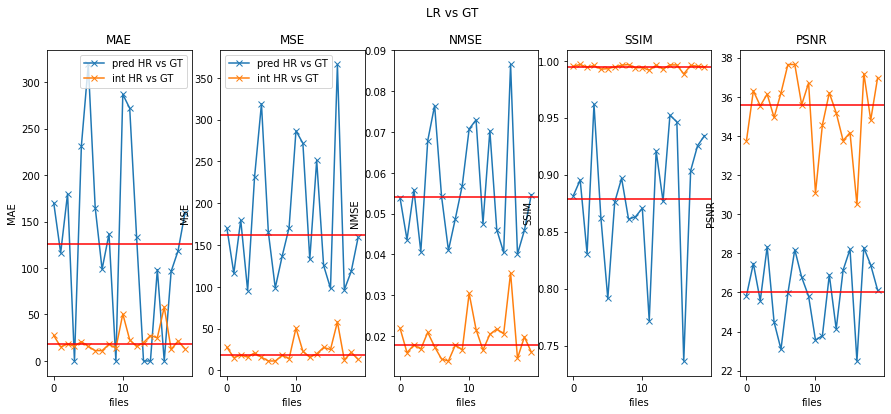

In [255]:
plot_metrics(df_lr,'LR', sim)

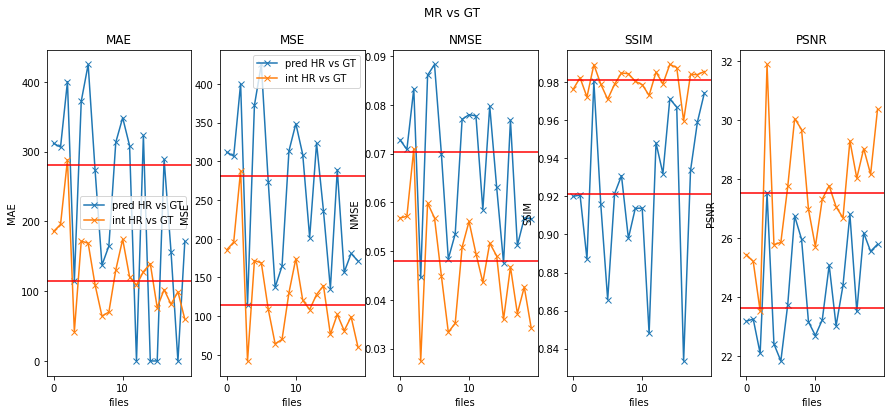

In [256]:
plot_metrics(df_mr,'MR',sim)

Note that the prediction from MR comes generally closer to the values of interpolated HR than from LR. It's almost never better though... 

In [247]:
import os
os.system('jupyter nbconvert --to html mod_model_on_superres_norm.ipynb')

0